In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode
import csv
import matplotlib.dates
from datetime import *
from sklearn import linear_model
from sklearn.preprocessing import *
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.externals import joblib
from fbprophet import Prophet

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [576]:
#导入训练数据
train_data = pd.read_csv('prophet_fusai_A_fullfilling_train_feature_set.csv')

print(train_data.head(10))

   date  brand  cnt  day_of_week  week  guess_date  date_year  date_month  \
0     1      1   31            2     0  2013-01-01       2013           1   
1     1      6    6            2     0  2013-01-01       2013           1   
2     1      9   15            2     0  2013-01-01       2013           1   
3     2      9    0            3     0  2013-01-02       2013           1   
4     2      8    0            3     0  2013-01-02       2013           1   
5     2      3    0            3     0  2013-01-02       2013           1   
6     2      2    0            3     0  2013-01-02       2013           1   
7     2      7   30            3     0  2013-01-02       2013           1   
8     2      6    6            3     0  2013-01-02       2013           1   
9     2      4   20            3     0  2013-01-02       2013           1   

   date_property guess_date_str    ...     brand_1 brand_2  brand_3  brand_4  \
0              2     2013-01-01    ...           1       0        0     

In [577]:
#根据prophet定义训练集
# df_allBrand = train_data[:][['guess_date', 'cnt', 'brand']]
df_allBrand = train_data
df_allBrand['guess_date'] = df_allBrand['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_allBrand.rename(columns = {'guess_date':'ds', 'cnt':'y', 'brand':'brand'}, inplace=True)
df_brand9 = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][df_allBrand.brand == 9]
df_brand9['y'] = df_brand9['y'].map(lambda x: None if x > 1500 else x)

#定义最大值和最小值
df_brand9['cap'] = 1800
df_brand9['floor'] = -500

print(df_brand9.head(10))

           ds       y  day_of_week_1  day_of_week_2  day_of_week_3  \
2  2013-01-01    15.0              0              1              0   
3  2013-01-02     0.0              0              0              1   
16 2013-01-03     0.0              0              0              0   
28 2013-01-04  1314.0              0              0              0   
37 2013-01-05   829.0              0              0              0   
46 2013-01-06   412.0              0              0              0   
50 2013-01-07   381.0              1              0              0   
58 2013-01-08   399.0              0              1              0   
69 2013-01-09   544.0              0              0              1   
82 2013-01-10   439.0              0              0              0   

    day_of_week_4  day_of_week_5  day_of_week_6  day_of_week_7  \
2               0              0              0              0   
3               0              0              0              0   
16              1              

In [578]:
#为模型添加节假日特征
#元旦
NewYearDay = pd.DataFrame({
  'holiday': 'NewYearDay',
  'ds': pd.to_datetime(['2013-01-01', '2013-01-02', '2013-01-03',
                        '2014-01-01', 
                        '2015-01-01', '2015-01-02', '2015-01-03',
                        '2016-01-01', '2016-01-02', '2016-01-03'])
})

#春节
ChineseNewYearDay = pd.DataFrame({
  'holiday': 'ChineseNewYearDay',
  'ds': pd.to_datetime(['2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15',
                        '2014-01-31', '2014-02-01', '2014-02-03', '2014-02-04', '2014-02-05', '2014-02-06', '2014-05-02', 
                        '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24',
                        '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13'])
})

#国庆节
NationalDay = pd.DataFrame({
  'holiday': 'NationalDay',
  'ds': pd.to_datetime(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04', '2013-10-05', '2013-10-06', '2013-10-07',
                        '2014-10-01', '2014-10-02', '2014-10-03', '2014-10-04', '2014-10-05', '2014-10-06', '2014-10-07', 
                        '2015-10-01', '2015-10-02', '2015-10-03', '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07',
                        '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07'])
})

#劳动节
MayDay = pd.DataFrame({
  'holiday': 'MayDay',
  'ds': pd.to_datetime(['2013-04-29', '2013-04-30', '2013-05-01',
                        '2014-05-01', '2014-05-02', '2014-05-03',  
                        '2015-05-01', '2015-05-02', '2015-05-03',
                        '2016-05-01', '2016-05-02', '2016-04-30'])
})

#清明节
ChingMingDay = pd.DataFrame({
  'holiday': 'ChingMingDay',
  'ds': pd.to_datetime(['2013-04-04', '2013-04-05', '2013-04-06',
                        '2014-04-05', '2014-04-06', '2014-04-07',  
                        '2015-04-04', '2015-04-05', '2015-04-06',
                        '2016-04-02', '2016-04-03', '2016-04-04'])
})

#端午节
DragonBoatDay = pd.DataFrame({
  'holiday': 'DragonBoatDay',
  'ds': pd.to_datetime(['2013-06-10', '2013-06-11', '2013-06-12',
                        '2014-05-31', '2014-06-01', '2014-06-02',  
                        '2015-06-20', '2015-06-21', '2015-06-22',
                        '2016-06-09', '2016-06-10', '2016-06-11'])
})

#中秋节
MidAutumnDay = pd.DataFrame({
  'holiday': 'MidAutumnDay',
  'ds': pd.to_datetime(['2013-09-19', '2013-09-20', '2013-09-21',
                        '2014-09-06', '2014-09-07', '2014-09-08',  
                        '2015-09-26', '2015-09-27',
                        '2015-09-03', '2015-09-04', '2015-09-05',
                        '2016-09-15', '2016-09-16', '2016-09-17'])
})

holidays = pd.concat((NewYearDay, ChineseNewYearDay, NationalDay, MayDay, ChingMingDay, DragonBoatDay, MidAutumnDay))


In [579]:
#手动设置changepoints集合
changepoints = ['2013-10-01', '2014-10-01', '2015-10-01']

In [580]:
#定义prophet模型和预测集
# m = Prophet()
m = Prophet(growth = 'logistic', holidays = holidays, changepoints = changepoints, changepoint_prior_scale = 0.5, 
           interval_width = 0.95)
m.add_seasonality(name = 'weekly', period = 7, fourier_order = 3)

m.add_regressor('day_of_week_1')
m.add_regressor('day_of_week_2')
m.add_regressor('day_of_week_3')
m.add_regressor('day_of_week_4')
m.add_regressor('day_of_week_5')
m.add_regressor('day_of_week_6')
m.add_regressor('day_of_week_7')

m.add_regressor('date_property_0')
m.add_regressor('date_property_1')
m.add_regressor('date_property_2')

m.add_regressor('is_newYearDay')
m.add_regressor('is_NationalDay')
m.add_regressor('is_ChineseNewYearDay')

m.add_regressor('after_restday_one')
m.add_regressor('after_holiday_one')
m.add_regressor('is_holi_restday')
m.add_regressor('isHolidayWeekend')
m.add_regressor('isPureWeekend')

m.fit(df_brand9)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [581]:
# future = m.make_future_dataframe(periods = 100)
# future['cap'] = 1500
# future['floor'] = 10

#导入预测数据集
# test_data = pd.read_csv('fusai_A_test_feature_set.csv')
test_data = pd.read_csv('prophet_fusai_A_fullfilling_test_feature_set.csv')
test_data['guess_date'] = test_data['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))

test_data_brand9 = test_data[['guess_date', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][test_data.brand == 9]
# test_data_brand9 = test_data[['guess_date']][test_data.brand == 9]
test_data_brand9.rename(columns = {'guess_date':'ds'}, inplace=True)
test_data_brand9 = pd.concat([df_brand9.drop('y', 1), test_data_brand9])
test_data_brand9['cap'] = 1800
test_data_brand9['floor'] = -500
print(test_data_brand9.head(10))
# future['day_of_week_1'] = future['ds'].map(lambda x: test_data_brand9['day_of_week_1'][test_data_brand9.guess_date == x].values)
# print(future.tail(10))

    after_holiday_one  after_restday_one   cap  date_property_0  \
2                   0                  0  1800                0   
3                   0                  0  1800                0   
16                  0                  0  1800                0   
28                  1                  1  1800                1   
37                  0                  0  1800                1   
46                  0                  0  1800                1   
50                  0                  0  1800                1   
58                  0                  0  1800                1   
69                  0                  0  1800                1   
82                  0                  0  1800                1   

    date_property_1  date_property_2  day_of_week_1  day_of_week_2  \
2                 0                1              0              1   
3                 0                1              0              0   
16                0                1              0 

In [583]:
forcast = m.predict(test_data_brand9)
print(forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast.ds < '2016-01-10') & (forcast.ds > '2016-01-01')])


             ds         yhat  yhat_lower   yhat_upper
1280 2016-07-04   813.359371  461.174047  1168.456781
1281 2016-07-05   825.879509  502.880260  1178.481193
1282 2016-07-06   776.740643  425.892028  1129.965422
1283 2016-07-07   676.525733  316.244400  1024.846868
1284 2016-07-08   765.432598  411.552565  1124.841341
1285 2016-07-09   345.868256   -4.432689   712.725098
1286 2016-07-10   242.949528 -106.386967   576.110484
1287 2016-07-11   831.538050  479.792349  1212.377601
1288 2016-07-12   840.667862  465.015535  1175.700579
1289 2016-07-13   788.059323  430.432251  1131.805726
1290 2016-07-14   684.351326  331.749519  1050.029896
1291 2016-07-15   769.798528  429.591460  1126.435210
1292 2016-07-16   346.864521  -41.899184   689.133195
1293 2016-07-17   240.721252  -85.490050   594.522593
1294 2016-07-18   826.282870  461.942771  1177.856851
1295 2016-07-19   832.632177  468.720956  1145.757613
1296 2016-07-20   777.533499  426.822972  1158.801119
1297 2016-07-21   671.663944

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


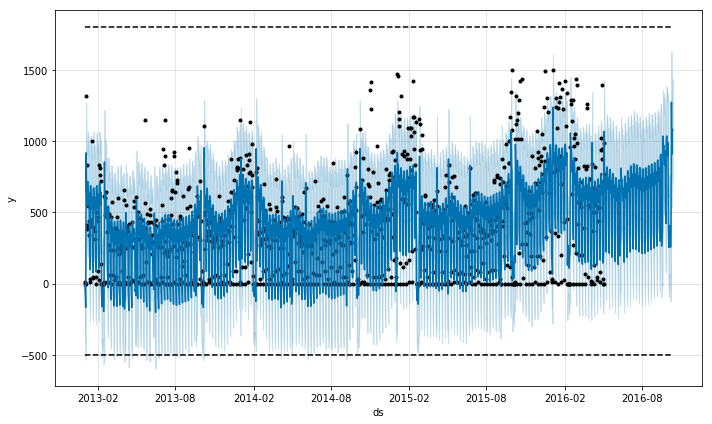

In [575]:
m.plot(forcast)